# Potential impact of severe storm Lothar (1999) on healthcare network in Baden-Württemberg, Germany

This *jupyter notebook* gives you a first hand user experience of climate risk modelling using a real life example - winterstorm Lothar that hit central Europe in December 1999. This notebook is based on the state-of-the-art risk modelling suite CLIMADA available open-source on GitHub.

If you are already stuck because you don't know what jupyter notebooks are, take a breath and start reading here: <br> https://jupyter.org/try-jupyter/notebooks/?path=notebooks/Intro.ipynb

While this notebook might be difficult to fully comprehend on first sight, you will learn about its power while you walk trough it and become more experienced. You will see that the application is not limited to storm Lothar, nor to the healthcare system and even not only to storms and not to Baden-Würrtemberg and not to past events and and and...

*Enjoy to dive into climate risk modeling!* :)


**To start with - what is CLIMADA?**

CLIMADA is a fully probabilistic climate risk assessment tool. It provides a framework for users to combine exposure, hazard and vulnerability or impact data to calculate risk. Users can create probabilistic impact data from event sets, look at how climate change affects these impacts, and see how effectively adaptation measures can change them. CLIMADA also allows for studies of individual events, historical event sets and forecasts.

### Installing CLIMADA python package on your computer
Before starting, follow the installation instructions to install the CLIMADA python package
<br> https://climada-python.readthedocs.io/en/stable/guide/install.html

After successful installation you may want to look at the available CLIMADA tutorials to familiarize yourself with CLIMADA 
<br> https://climada-python.readthedocs.io/en/stable/tutorial/1_main_climada.html

### Additional installation requirements
In addition to the regular installation of CLIMADA (above), this notebook requires an additional python package and an open street map (osm) file for Baden-Württemberg

In order to run, please 
1) run *pip install osm-flex*
2) download the open street map (osm) file for Baden-Württemberg, by issueing (in a browser): <br> https://download.geofabrik.de/europe/germany/baden-wuerttemberg-latest.osm.pbf
3) move the file to the local folder where CLIMADA stores osm files. The easiest way to figure is to run *path_osm_dump = dl.get_country_geofabrik('LUX')* and then move the file baden-wuerttemberg-latest.osm.pbf to the folder ../osm/osm_bpf/
4) edit the path_osm_dump in the cell with the comment ***EDIT HERE***
5) run the notebook

### Start modeling

In [2]:
# !pip install osm-flex # has to be installed

# Loading necessary data packages
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import datetime as dt

#Load OSM Flex, see
# Mühlhofer, E., Kropf, C., Riedel,. L., Bresch, D. N., and Koks, E., 2023: 
# OpenStreetMap for Multi-Faceted Climate Risk Assessments. 
# Environ. Res. Commun., 6, 015005, https://doi.org/10.1088/2515-7620/ad15ab 
import osm_flex
import osm_flex.download as dl
import osm_flex.extract as ex
import osm_flex.config
import osm_flex.clip as cp
osm_flex.enable_logs()

### Preparing the exposure

In [3]:
# this had to be run only if file has not been downloaded previously
### Might take some time to download - be patient
path_osm_dump = dl.get_country_geofabrik('DEU')

In [3]:
# in case one has obtained the file already, e.g. from your browser, like
# https://download.geofabrik.de/europe/germany/baden-wuerttemberg-latest.osm.pbf
path_osm_dump = 'baden-wuerttemberg-latest.osm.pbf' # ***EDIT HERE***

In [4]:
# define the country
iso3 = 'DEU' # the ISO3-code of the country, e.g. 'DEU'

In [5]:
# in case one wants to digest a whole country (several GB for DEU)
#path_osm_dump = dl.get_country_geofabrik(iso3)
#print(f'Saved as {path_osm_dump}')

In [5]:
# available wrapper categories in the OSM data
osm_flex.config.DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'main_road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food', 'buildings'])

In [6]:
# Extracting the healthcare infrastructure (this does take a bit of time)
gdf = ex.extract_cis(path_osm_dump, 'healthcare')
#Available features for the healthcare category
gdf.healthcare.unique()

/home/vclimada/miniforge3/envs/climada/lib/python3.11/site-packages/osgeo/ogr.py:601: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
INFO:osm_flex.extract:query is finished, lets start the loop
extract points: 100%|██████████| 4538/4538 [00:13<00:00, 329.05it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 100%|██████████| 1871/1871 [01:35<00:00, 19.55it/s]


array(['clinic', 'hospital', None, 'doctor', 'centre',
       'occupational_therapist', 'physiotherapist', 'psychotherapist',
       'podiatrist', 'alternative', 'general_practitioner',
       'rehabilitation', 'dentist', 'midwife',
       'alternative;doctor;psychotherapist', 'speech_therapist',
       'speech_therapist,physiotherapist', 'dialysis', 'optometrist',
       'laboratory', 'sample_collection', 'radiology',
       'doctor;physiotherapist', 'doctor;dialysis', 'birthing_centre',
       'doctor;clinic', 'yes', 'surgery', 'orthopaedics',
       'doctor;alternative', 'centre;dialysis', 'pharmacy', 'neurology',
       'blood_donation', 'hospital;dialysis'], dtype=object)

/tmp/ipykernel_73202/1796880630.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  healthcare['geometry'] = healthcare['geometry'].centroid


Text(0.5, 1.0, 'Hospitals in Baden-Württemberg')

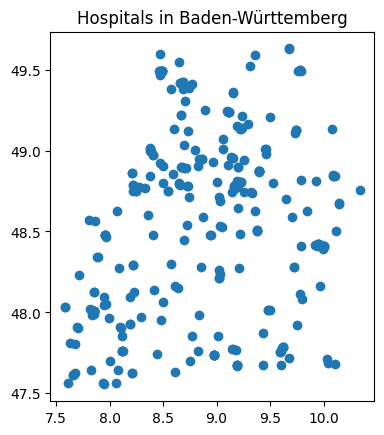

In [131]:
# pick the hospitals as proxy for impacts to the healthcare system
healthcare = gdf.loc[gdf['healthcare']=='hospital']
# treat multipolygons as points for simplicity
healthcare['geometry'] = healthcare['geometry'].centroid 
healthcare.plot()
plt.title('Hospitals in Baden-Württemberg')

In [132]:
from climada.entity import Exposures
import cartopy.crs as ccrs
import cartopy.feature as cfeature

exp = Exposures(healthcare)
# associate additional information with the exposure
exp.gdf['value'] = 1 # all hospitals have identical value for simplicity
exp.gdf['impf_WS'] = 1 # all hospitals are identically affected by wind for simplicity
exp.gdf['longitude'] = exp.gdf['geometry'].x
exp.gdf['latitude'] = exp.gdf['geometry'].y

In [178]:
exp.gdf[:5]

,osm_id,amenity,building,healthcare,name,geometry,value,impf_WS,longitude,latitude,centr_WS
1,152752717,hospital,None,hospital,MEDIAN Klinik Gunzenbachhof,POINT (8.24403 48.74863),1,1,8.244032,48.748629,3975
2,187038343,None,None,hospital,"Klinik für Psychiatrie, Psychotherapie und Psy...",POINT (7.85621 48.00696),1,1,7.856208,48.006963,1476
3,195441656,hospital,None,hospital,Caritas-Krankenhaus,POINT (9.76312 49.49048),1,1,9.763116,49.490481,6859
8,267041564,hospital,None,hospital,Ortenau Klinikum Offenburg-Gengenbach,POINT (7.95554 48.47615),1,1,7.955541,48.476147,2952
14,281397952,hospital,None,hospital,Evangelisches Diakoniewerk Schwäbisch Hall,POINT (9.74230 49.12479),1,1,9.742300,49.124786,5433


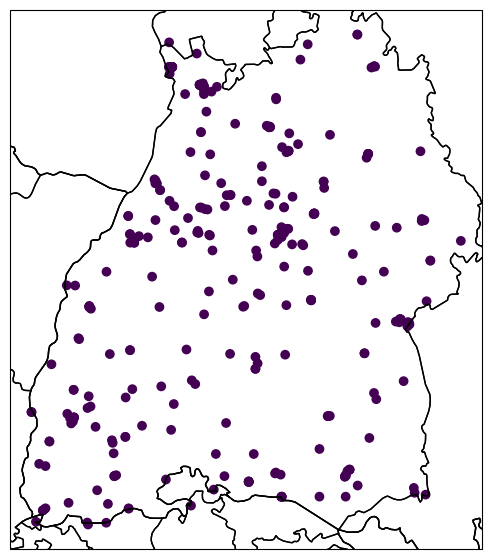

In [134]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,7))
exp.gdf.plot('value',ax=ax)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

### Preparing the hazard

In [9]:
# fetch the hazard from the CLIMADA data API (this might take a while to download)
from climada.util.api_client import Client
haz_prob = Client().get_hazard('storm_europe', properties={'country_iso3alpha': iso3})
lothar_start_end = ['1999-12-25', '1999-12-27']
haz = haz_prob.select(date=lothar_start_end, orig=True)

<GeoAxesSubplot:title={'center':'Event ID 15100: 15100'}>

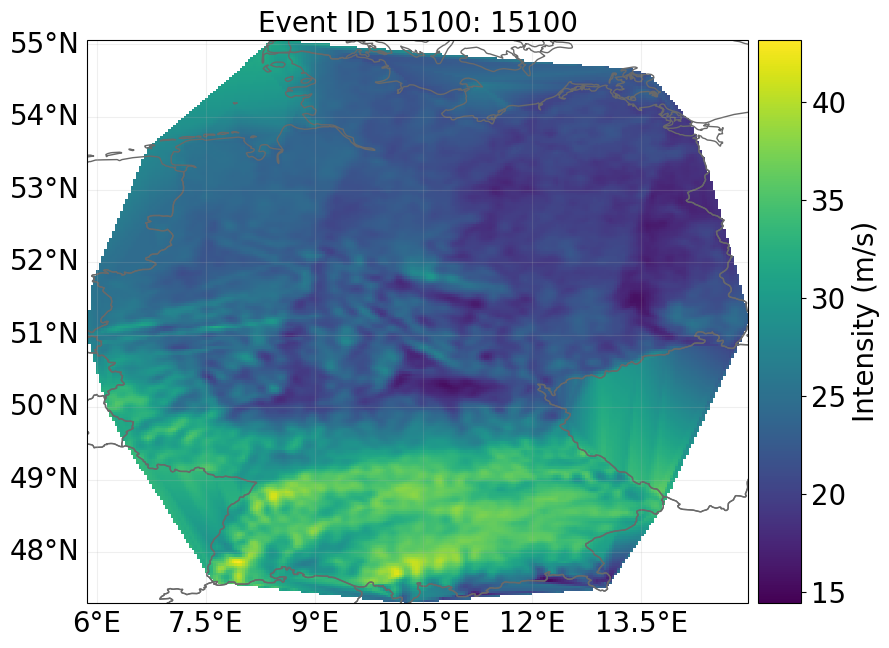

In [33]:
# plot the wind footprint of storm Lothar over Germany
haz.plot_intensity(haz.event_id[0])

### Preparing the vulnerability function

<AxesSubplot:title={'center':'WS 1: '}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

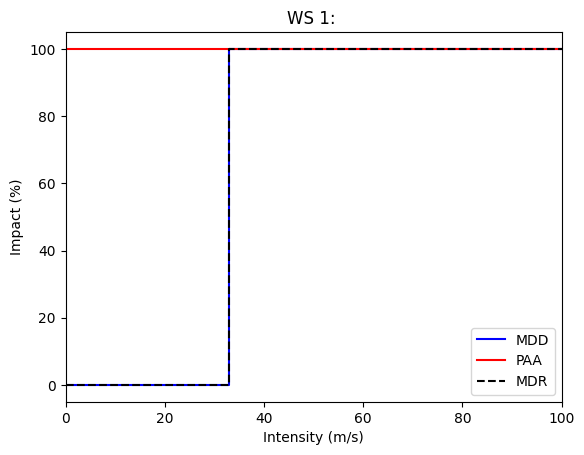

In [183]:
#Assume simple step function, indicating a hospital is affected by wind above an intensity of 33m/s ( Bf 12 - Orkan)
from climada.entity import ImpactFunc,ImpactFuncSet
#wind_threshold = 26 # m/s gust speed threshold (helicopers not allowed to fly > 50knots)
wind_threshold = 33 # m/s gust speed threshold (Orkan Bf 12)
impf = ImpactFunc.from_step_impf(intensity=(0,wind_threshold,100),haz_type='WS')
impf.intensity_unit = haz.units
impfset = ImpactFuncSet([impf])
impfset.plot()

### Preparing the impact

In [184]:
#Calculate impacts on hospitals
from climada.engine import ImpactCalc
imp = ImpactCalc(exp, impfset, haz).impact()
imp.unit= f'Affected hospitals [fraction with >{wind_threshold}m/s]'

In [185]:
#Define plotting functions
def plot_event_imp_geom(imp_geom,exp_geom, event_id, figsize=(9, 13), **kwargs):
    """
    Plot the average impact per exposure polygon. Adapted from
    climada.util.lines_polys_handler.plot_eai_exp_geom
    """

    kwargs['figsize'] = figsize
    if 'legend_kwds' not in kwargs:
        kwargs['legend_kwds'] = {
            'label': f"Impact [{imp_geom.unit}]",
            'orientation': "horizontal"
            }
    if 'legend' not in kwargs:
        kwargs['legend'] = True
    gdf_plot = gpd.GeoDataFrame(exp_geom.gdf.geometry)
    gdf_plot['impact'] = imp_geom.imp_mat[imp_geom.event_id==event_id,:].todense().A1
    return gdf_plot.plot(column = 'impact', **kwargs)

def plot_event(date_str,imp,exp,plot_haz=True):
    """
    Plot the average impact per exposure polygon for a given date.
    """
    fig,ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,7))
    event_id = imp.event_id[imp.date==dt.datetime.strptime(date_str,"%Y-%m-%d").toordinal()][0]
    if not plot_haz:
        plot_event_imp_geom(imp,exp,event_id,figsize=(10,7),cmap='cividis_r',legend=True,ax=ax,legend_kwds={'label': imp.unit,'shrink': 0.8})
        ax.set_title(f'Modelled hospitals affected by storm on {date_str}')
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES)
    else:
        haz.plot_intensity(event_id,axis=ax)
        plot_event_imp_geom(imp,exp,event_id,figsize=(10,7),markersize=3,cmap='Oranges',legend=True,ax=ax,
                            legend_kwds={'label': imp.unit,
                                         'shrink': 0.5,'orientation': 'horizontal',
                                         'pad': 0.1})
        ax.set_title(f'Modelled hospitals affected by storm on {date_str}')
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES)
    return ax

<GeoAxesSubplot:title={'center':'Modelled hospitals affected by storm on 1999-12-26'}>

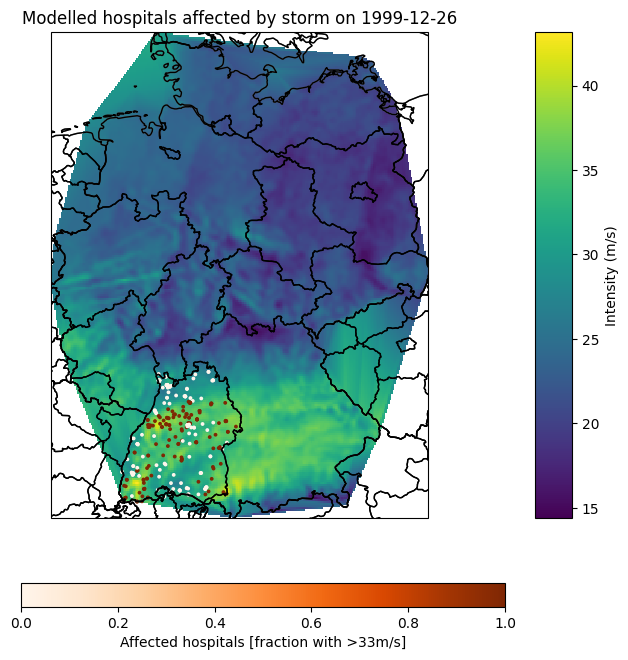

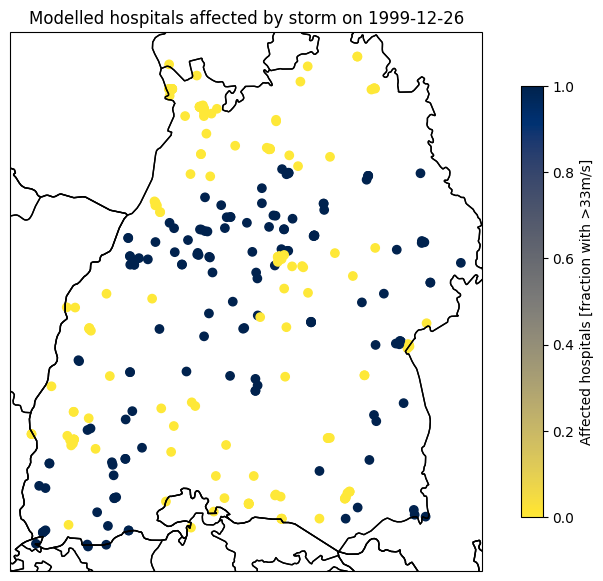

In [186]:
plot_event("1999-12-26",imp,exp)
plot_event("1999-12-26",imp,exp,plot_haz=False)